In [70]:
import torch
import pandas as pd
from helpers import *
from sklearn.model_selection import train_test_split
from eval import get_predictions
import evaluate
import warnings
import numpy as np
from scipy.special import softmax
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoConfig, AutoModelForTokenClassification, DataCollatorForTokenClassification
from dataset_loaders import MaterialSynthesisDataset
import os
import time
import eval
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss

In [71]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [72]:
path = "data/ner_annotations.json"
sentences, all_labels, label_list, label_dict = load_data(path)

X_train, X_rest, y_train, y_rest = train_test_split(
    sentences,
    all_labels,
    test_size=0.66666,
    random_state=1
    )

X_test, X_val, y_test, y_val = train_test_split(
    X_rest,
    y_rest,
    test_size=0.5,
    random_state=1
    )

In [73]:
model_checkpoint = "models/baseline/distilbert-base-uncased-baseline-finetuned"
max_input_length = 300
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint,
    model_max_length=max_input_length,
    add_prefix_space=True
    )
train_data = MaterialSynthesisDataset(
    X_train,
    y_train,
    label_dict,
    tokenizer,
    max_input_length
    )
test_data = MaterialSynthesisDataset(
    X_test,
    y_test,
    label_dict,
    tokenizer,
    max_input_length
    )
val_data = MaterialSynthesisDataset(
    X_val,
    y_val,
    label_dict,
    tokenizer,
    max_input_length
    )

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [74]:
data_collator = DataCollatorForTokenClassification(tokenizer)
# config = AutoConfig.from_pretrained(
#     model_checkpoint,
#     num_labels=len(label_list),
#     id2label={str(i): key for key, i in label_dict.items()},
#     label2id={key: i for key, i in label_dict.items()}
# )
# model = AutoModelForTokenClassification.from_config(config)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

model_name = model_checkpoint.split('/')[-1]
log_dir = time.strftime("%Y%m%d-%H%M%S") + '_' + model_name
os.mkdir('./tb_logs/'+ log_dir)

loading configuration file models/baseline/distilbert-base-uncased-baseline-finetuned/config.json
Model config DistilBertConfig {
  "_name_or_path": "models/baseline/distilbert-base-uncased-baseline-finetuned",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "null",
    "1": "target",
    "2": "number",
    "3": "unspecified-material",
    "4": "operation",
    "5": "condition-misc",
    "6": "precursor",
    "7": "amount-unit",
    "8": "property-unit",
    "9": "reference",
    "10": "material",
    "11": "apparatus-unit",
    "12": "apparatus-descriptor",
    "13": "synthesis-apparatus",
    "14": "brand",
    "15": "condition-unit",
    "16": "property-misc",
    "17": "meta",
    "18": "material-descriptor",
    "19": "solvent",
    "20": "amount-misc",
    "21": "nonrecipe-material",
    "22": "characterization-apparatus",
    "23": "

In [75]:
seqeval_metric = evaluate.load("seqeval")
f1_metric = evaluate.load("f1")
roc_auc_score = evaluate.load("roc_auc", "multiclass")

In [76]:
batch_size = 16
args = TrainingArguments(
    f"./models/baseline/{model_name}",
    # f"./models/baseline/{model_name}-baseline-finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    save_strategy="steps",
    evaluation_strategy = 'steps',
    eval_steps=100,
    report_to='tensorboard',
    logging_strategy = 'steps',
    logging_dir='./tb_logs/'+ log_dir,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=eval.compute_metrics
)

PyTorch: setting up devices


In [50]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.train()

***** Running training *****
  Num examples = 721
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 138
  Number of trainable parameters = 66383643


  0%|          | 0/138 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 722
  Batch size = 16


  0%|          | 0/46 [00:00<?, ?it/s]

{'eval_loss': 1.4716719388961792, 'eval_precision': 0.3484073928430987, 'eval_recall': 0.18535564853556485, 'eval_f1': 0.24197733169466062, 'eval_accuracy': 0.6001070868550885, 'eval_runtime': 30.5566, 'eval_samples_per_second': 23.628, 'eval_steps_per_second': 1.505, 'epoch': 2.17}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 370.5784, 'train_samples_per_second': 5.837, 'train_steps_per_second': 0.372, 'train_loss': 1.7494819751684216, 'epoch': 3.0}


In [51]:
trainer.save_model("./models/baseline/" + f"{model_name}-baseline-finetuned")

Saving model checkpoint to ./models/baseline/distilbert-base-uncased-baseline-finetuned
Configuration saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned/config.json
Model weights saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned/pytorch_model.bin
tokenizer config file saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned/tokenizer_config.json
Special tokens file saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned/special_tokens_map.json


In [79]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        logits,
        id_predictions,
        id_labels,
        real_predictions,
        real_labels
    ) = get_predictions(trainer, test_data, label_list)

    seqeval_metric = evaluate.load("seqeval")
    results_seqeval = seqeval_metric.compute(predictions=real_predictions, references=real_labels)
    print({
        'overall_precision' : np.round(results_seqeval['overall_precision'], 4),
        'overall_recall' : np.round(results_seqeval['overall_recall'], 4),
        'overall_f1' : np.round(results_seqeval['overall_f1'], 4),
        'overall_accuracy' : np.round(results_seqeval['overall_accuracy'], 4),
    })

***** Running Prediction *****
  Num examples = 722
  Batch size = 16
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/46 [00:00<?, ?it/s]

{'overall_precision': 0.3541, 'overall_recall': 0.4393, 'overall_f1': 0.3921, 'overall_accuracy': 0.5932}


In [80]:
# id-encoded predictions are necessary for weighted f1
flat_id_predictions = [i for m in id_predictions for i in m]
flat_id_labels = [j for n in id_labels for j in n]
results_f1 = f1_metric.compute(
    predictions=flat_id_predictions,
    references=flat_id_labels,
    average="weighted"
    )
print("weighted_f1:", np.round(results_f1["f1"], 4))

weighted_f1: 0.5346


In [81]:
# logits are necessary for roc auc
flat_logits = softmax([k for o in logits for k in o], axis=1)
results_roc_auc = roc_auc_score.compute(
    references=flat_id_labels,
    prediction_scores=flat_logits,
    multi_class='ovr',
    average=None
    )
print("roc_auc:", np.round(results_roc_auc["roc_auc"], 4))

roc_auc: [0.9233 0.8543 0.938  0.9012 0.9256 0.8985 0.8723 0.9435 0.6345 0.7734
 0.7786 0.7427 0.8697 0.8362 0.8001 0.9745 0.8589 0.847  0.8475 0.8009
 0.9053 0.7705 0.8149 0.836  0.8848 0.8001 0.6926]


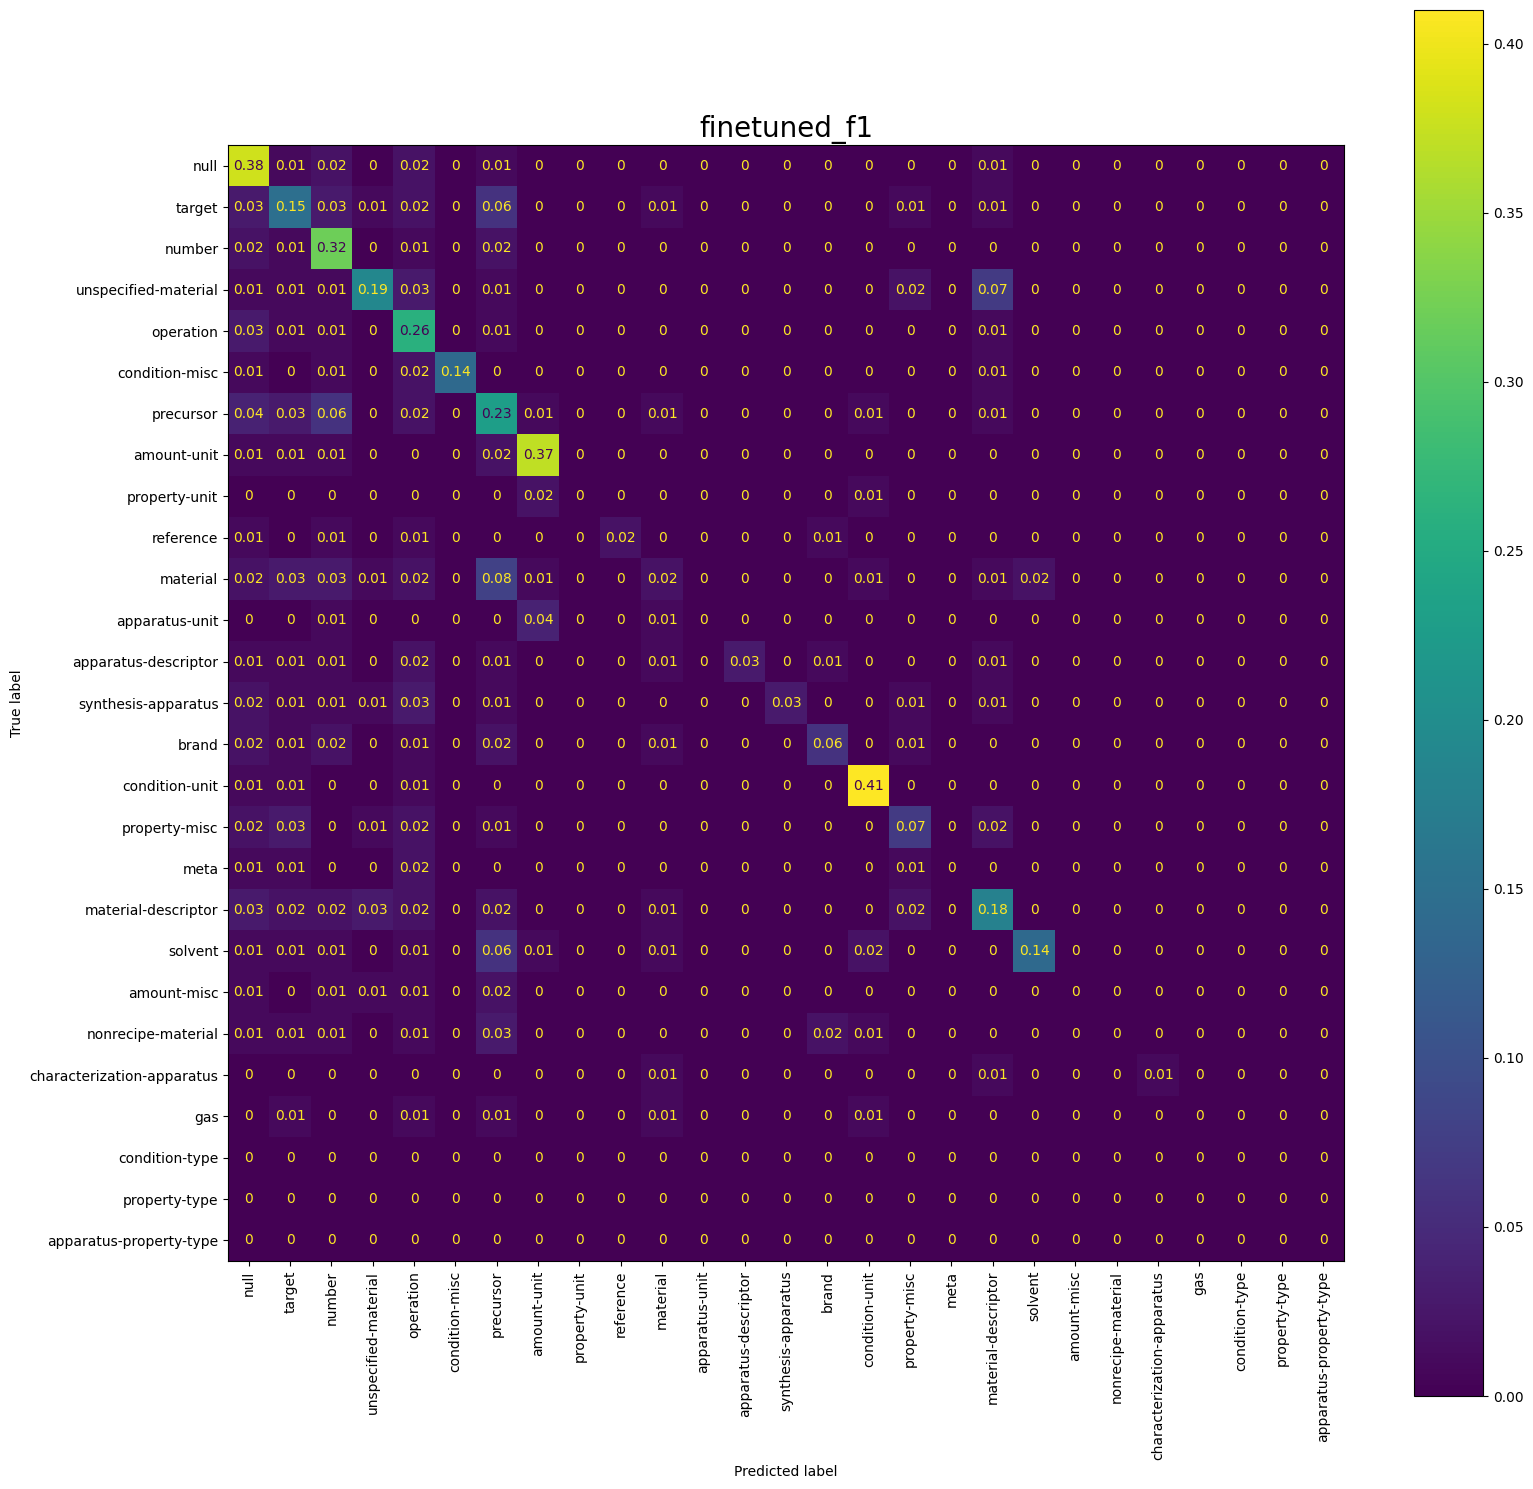

In [100]:
flat_real_predictions = [i for m in real_predictions for i in m]
flat_real_labels = [j for n in real_labels for j in n]
cm_recall = metrics.confusion_matrix(flat_real_labels, flat_real_predictions, labels=label_list, normalize="true")
cm_precision = metrics.confusion_matrix(flat_real_labels, flat_real_predictions, labels=label_list, normalize="pred")
cm_sum = cm_precision + cm_recall
cm_sum[cm_sum==0] = 1 # just to avoid division by 0
cm_f1 = (cm_precision*cm_recall)/cm_sum
cm = np.round(cm_f1, 2)
disp = ConfusionMatrixDisplay(cm, display_labels=label_list).plot(xticks_rotation='vertical')
fig = disp.figure_
disp.ax_.set_title('finetuned_f1', {'fontsize': 20})
fig.set_figwidth(18)
fig.set_figheight(18)
plt.show()
# fig.savefig(f"./images/{model_name}-results.png", dpi=300, format="png")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (   
        logits,
        id_predictions,
        id_labels,
        real_predictions,
        real_labels
    ) = get_predictions(trainer, train_data, label_list)

In [8]:
losses = []
for i, (l, p) in enumerate(zip(id_labels, logits)):
    losses.append((
        log_loss(l, softmax(p), labels=[n for n in range(len(label_list))]),
        (
        train_data.sentences[i],
        train_data.labels[i]
        )
    ))

file_id = time.strftime("%Y%m%d-%H%M%S") + '_'
with open(f"./{file_id}train_data_losses.pt", 'wb') as f:
    torch.save(losses, f)
print("data saved...")

data saved...


In [77]:
import torch
with open("./augmentations/20230811-161932_responses.pt", 'rb') as f:
    responses = torch.load(f)

for r in responses:
    r["choices"] = r["choices"][:3]

In [78]:
aug_sentences, aug_labels = extract_augmentations(responses, label_list)
print(len(aug_sentences))
for s in zip(aug_sentences[:3], aug_labels[:3]):
    print()
    print(s[0])
    print(s[1])

1420

['The', 'transparent', 'silica', 'gel', 'was', 'heated', 'at', 'a', 'high', 'temperature', 'of', '800°C', 'for', '4', 'hours', 'under', 'a', 'nitrogen', 'atmosphere']
['null', 'material-descriptor', 'precursor', 'precursor', 'null', 'null', 'null', 'null', 'number', 'number', 'null', 'amount-misc', 'null', 'amount-misc', 'amount-misc', 'null', 'null', 'operation', 'operation']

['Iron', '(', 'III', ')', 'chloride', 'was', 'dissolved', 'in', '100', 'mL', 'of', 'water', 'followed', 'by', 'the', 'addition', 'of', '10', 'g', 'of', 'glucose', 'under', 'constant', 'stirring']
['precursor', 'precursor', 'precursor', 'precursor', 'precursor', 'null', 'null', 'null', 'number', 'number', 'null', 'nonrecipe-material', 'null', 'null', 'null', 'null', 'null', 'number', 'number', 'null', 'nonrecipe-material', 'null', 'operation', 'operation']

['The', 'porous', 'activated', 'carbon', 'was', 'impregnated', 'with', 'a', 'small', 'amount', 'of', 'sulfuric', 'acid', 'and', 'dried', 'at', 'room', '

In [83]:
augmented_data = MaterialSynthesisDataset(
    aug_sentences,
    aug_labels,
    label_dict,
    tokenizer,
    max_input_length
    )

In [84]:
args = TrainingArguments(
    # f"./models/baseline/{model_name}",
    f"./models/baseline/{model_name}-prompt-augmented",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    save_strategy="steps",
    evaluation_strategy = 'steps',
    eval_steps=100,
    report_to='tensorboard',
    logging_strategy = 'steps',
    logging_dir='./tb_logs/'+ log_dir,
)

trainer = Trainer(
    model,
    args,
    train_dataset=augmented_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=eval.compute_metrics
)

PyTorch: setting up devices


In [85]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.train()

***** Running training *****
  Num examples = 1420
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 267
  Number of trainable parameters = 66383643


  0%|          | 0/267 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 722
  Batch size = 16


  0%|          | 0/46 [00:00<?, ?it/s]

{'eval_loss': 1.412166714668274, 'eval_precision': 0.2252032520325203, 'eval_recall': 0.2317991631799163, 'eval_f1': 0.22845360824742267, 'eval_accuracy': 0.6074884307951199, 'eval_runtime': 30.5345, 'eval_samples_per_second': 23.645, 'eval_steps_per_second': 1.506, 'epoch': 1.12}


***** Running Evaluation *****
  Num examples = 722
  Batch size = 16


  0%|          | 0/46 [00:00<?, ?it/s]

{'eval_loss': 1.3869872093200684, 'eval_precision': 0.22226331360946747, 'eval_recall': 0.2514644351464435, 'eval_f1': 0.23596387907341973, 'eval_accuracy': 0.6161318698129804, 'eval_runtime': 30.4814, 'eval_samples_per_second': 23.687, 'eval_steps_per_second': 1.509, 'epoch': 2.25}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 725.8224, 'train_samples_per_second': 5.869, 'train_steps_per_second': 0.368, 'train_loss': 1.5301913715033941, 'epoch': 3.0}


In [86]:
trainer.save_model(f"./models/baseline/{model_name}-prompt-augmented")

Saving model checkpoint to ./models/baseline/distilbert-base-uncased-baseline-finetuned-prompt-augmented
Configuration saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned-prompt-augmented/config.json
Model weights saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned-prompt-augmented/pytorch_model.bin
tokenizer config file saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned-prompt-augmented/tokenizer_config.json
Special tokens file saved in ./models/baseline/distilbert-base-uncased-baseline-finetuned-prompt-augmented/special_tokens_map.json


In [87]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        logits2,
        id_predictions2,
        id_labels2,
        real_predictions2,
        real_labels2
    ) = get_predictions(trainer, test_data, label_list)

    results_seqeval2 = seqeval_metric.compute(predictions=real_predictions2, references=real_labels2)
    print('finetuned:\n', {
        'overall_precision' : np.round(results_seqeval['overall_precision'], 4),
        'overall_recall' : np.round(results_seqeval['overall_recall'], 4),
        'overall_f1' : np.round(results_seqeval['overall_f1'], 4),
        'overall_accuracy' : np.round(results_seqeval['overall_accuracy'], 4),
    })
    print('augmented:\n', {
        'overall_precision' : np.round(results_seqeval2['overall_precision'], 4),
        'overall_recall' : np.round(results_seqeval2['overall_recall'], 4),
        'overall_f1' : np.round(results_seqeval2['overall_f1'], 4),
        'overall_accuracy' : np.round(results_seqeval2['overall_accuracy'], 4),
    })

***** Running Prediction *****
  Num examples = 722
  Batch size = 16


  0%|          | 0/46 [00:00<?, ?it/s]

finetuned:
 {'overall_precision': 0.3541, 'overall_recall': 0.4393, 'overall_f1': 0.3921, 'overall_accuracy': 0.5932}
augmented:
 {'overall_precision': 0.3568, 'overall_recall': 0.4952, 'overall_f1': 0.4148, 'overall_accuracy': 0.6026}


In [104]:
df = pd.DataFrame({
        'precision' : [np.round(results_seqeval['overall_precision'], 4), np.round(results_seqeval2['overall_precision'], 4)],
        'recall' : [np.round(results_seqeval['overall_recall'], 4), np.round(results_seqeval2['overall_recall'], 4)],
        'f1' : [np.round(results_seqeval['overall_f1'], 4), np.round(results_seqeval2['overall_f1'], 4)],
        'accuracy' : [np.round(results_seqeval['overall_accuracy'], 4), np.round(results_seqeval2['overall_accuracy'], 4)],
        'weighted_f1' : [np.round(results_f1["f1"], 4), np.round(results_f12["f1"], 4)],
    }, index=['finetuned', 'augmented'])
df

,precision,recall,f1,accuracy,weighted_f1
finetuned,0.3541,0.4393,0.3921,0.5932,0.5346
augmented,0.3568,0.4952,0.4148,0.6026,0.5714


In [88]:
# id-encoded predictions are necessary for weighted f1
flat_id_predictions2 = [i for m in id_predictions2 for i in m]
flat_id_labels2 = [j for n in id_labels2 for j in n]
results_f12 = f1_metric.compute(
    predictions=flat_id_predictions2,
    references=flat_id_labels2,
    average="weighted"
    )

print("finetuned_weighted_f1:", np.round(results_f1["f1"], 4))
print("augmented_weighted_f1:", np.round(results_f12["f1"], 4))

finetuned_weighted_f1: 0.5346
augmented_weighted_f1: 0.5714


In [89]:
# logits are necessary for roc auc
flat_logits2 = softmax([k for o in logits2 for k in o], axis=1)
results_roc_auc2 = roc_auc_score.compute(
    references=flat_id_labels2,
    prediction_scores=flat_logits2,
    multi_class='ovr',
    average=None
    )
df = pd.DataFrame({'finetuned': results_roc_auc["roc_auc"], 'augmented': results_roc_auc2["roc_auc"]}, index=label_list)
df

,finetuned,augmented
null,0.923292,0.921008
target,0.854327,0.853910
number,0.937977,0.942081
unspecified-material,0.901175,0.917195
operation,0.925606,0.941458
condition-misc,0.898468,0.882085
precursor,0.872327,0.886493
amount-unit,0.943546,0.949621
property-unit,0.634492,0.800310
reference,0.773406,0.792410


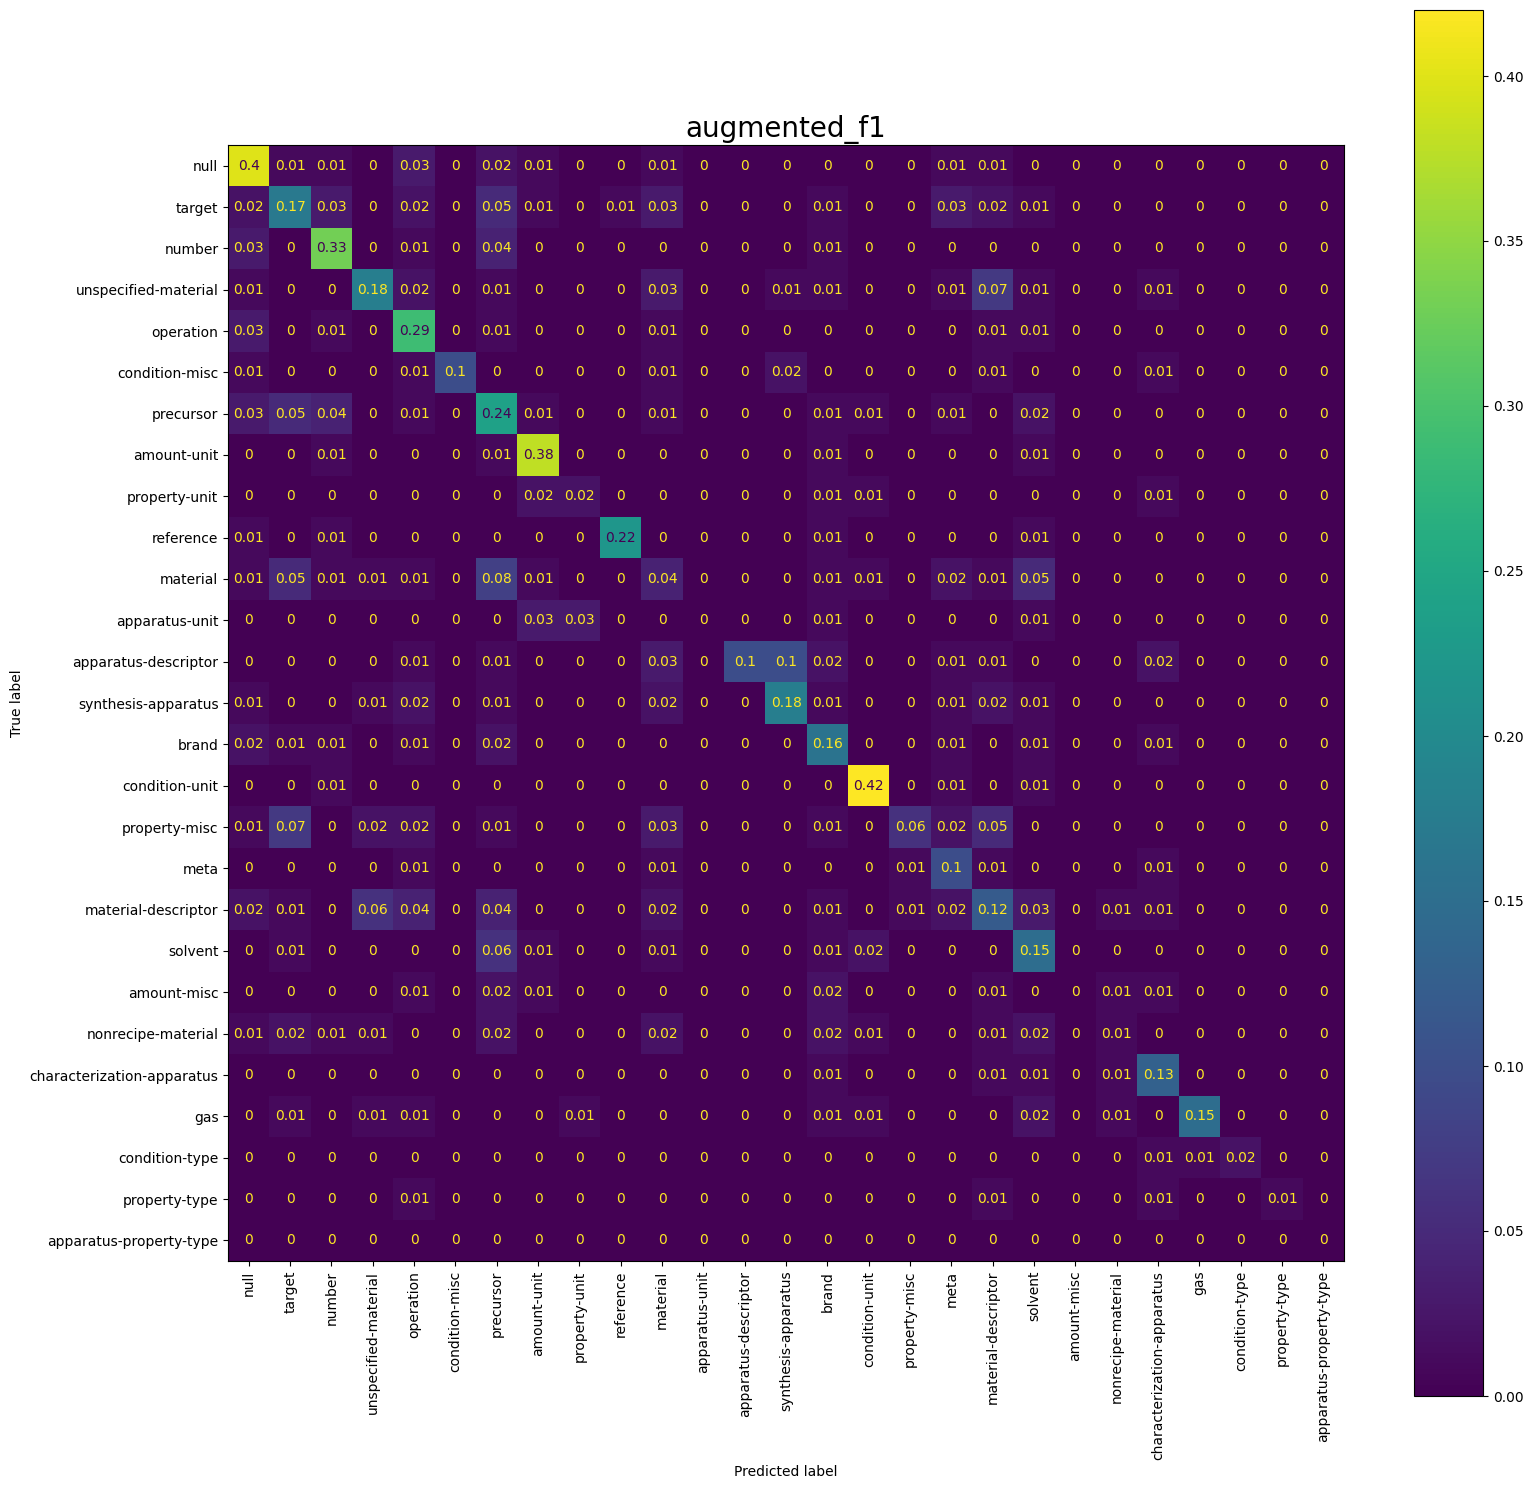

In [99]:
flat_real_predictions2 = [i for m in real_predictions2 for i in m]
flat_real_labels2 = [j for n in real_labels2 for j in n]
cm_recall2 = metrics.confusion_matrix(flat_real_labels2, flat_real_predictions2, labels=label_list, normalize="true")
cm_precision2 = metrics.confusion_matrix(flat_real_labels2, flat_real_predictions2, labels=label_list, normalize="pred")
cm_sum2 = cm_precision2 + cm_recall2
cm_sum2[cm_sum2==0] = 1 # just to avoid division by 0
cm_f12 = (cm_precision2*cm_recall2)/cm_sum2
cm2 = np.round(cm_f12, 2)
disp = ConfusionMatrixDisplay(cm2, display_labels=label_list).plot(xticks_rotation='vertical')
fig = disp.figure_
disp.ax_.set_title('augmented_f1', {'fontsize': 20})
fig.set_figwidth(18)
fig.set_figheight(18)
plt.show()
# fig.savefig(f"./images/{model_name}-results.png", dpi=300, format="png")